# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

### Load data

In [1]:
import pandas as pd
import numpy as np
import math
import json
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [4]:
transcript.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


### 1. Portfolio data

#### 1.1 Data understanding

In [ ]:
portfolio.head(5)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


#### 1.2 Data cleaning and transformation

In [5]:
# Split the channels column into 1/0s column
channels_list = ['email', 'mobile', 'social', 'web']

for channel in channels_list:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)

# Drop the original 'channels' column
portfolio.drop(columns=['channels'], inplace=True)
portfolio

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


#### 1.3 Data visualization

<AxesSubplot: >

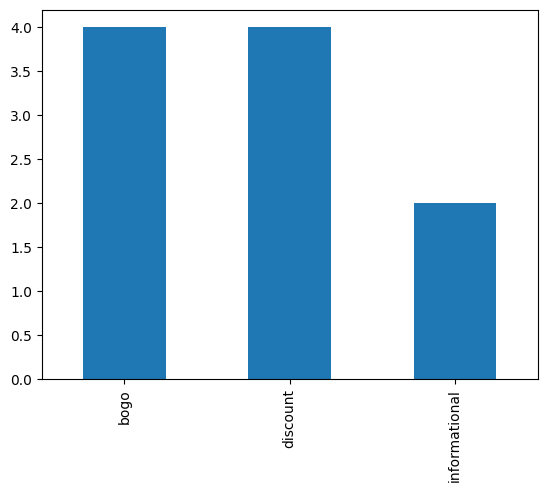

In [6]:
portfolio["offer_type"].value_counts().plot.bar()

#### 1.4 Summary about Portfolio data:
- Buy one get one offer (BOGO): Has the reward and difficulty equal.
- Discount: Difficulty higher than reward.
- All the available offers are sent to email

### 2. Profile data

#### 2.1 Data understanding

In [7]:
profile.head(5)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


#### 2.2 Data cleaning and transformation

In [8]:
# Decide to change the profile the row which is Age = 118, Income = Nan and Gender = None to age = Nan
import numpy as np
profile.loc[((profile["age"] == 118) & (profile["income"].isna()) & (profile["gender"].isna())),"age"] = np.nan

In [9]:
profile[(profile["age"].isna()) & (profile["income"].isna()) & (profile["gender"].isna())].head(5)

,gender,age,id,became_member_on,income
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,NaN,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,NaN,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


In [10]:
profile.describe()

,age,became_member_on,income
count,14825.000000,1.700000e+04,14825.000000
mean,54.393524,2.016703e+07,65404.991568
std,17.383705,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016053e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


#### 2.3 Data visualization

array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'became_member_on'}>],
       [<AxesSubplot: title={'center': 'income'}>, <AxesSubplot: >]],
      dtype=object)

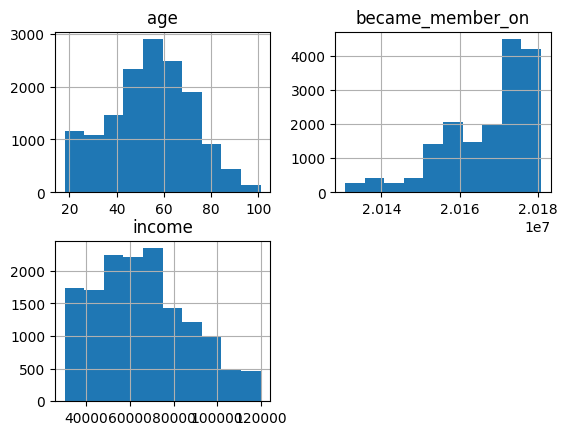

In [11]:
profile.hist()

In [12]:
profile.head(5)

,gender,age,id,became_member_on,income
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


#### 2.4 Summary about Profile data
- Age and income chart have the normal distribution with mean 54 and 65404 respectively
- became_member_on shows that the large of member is registered in 2018

### 3. Transcript data

#### 3.1 Data understanding

In [2]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


#### 3.2 Data cleaning and transformation

In [13]:
# Clean data: 
# Check whether value in person column is availabled in profile
person_ids = profile["id"].unique()
is_values_present = transcript['person'].isin(person_ids)
filtered_df = transcript[~is_values_present]
filtered_df

,person,event,value,time


In [15]:
transcript_clean = transcript
transcript_clean['offer_id'] = transcript['value'].apply(lambda x: x.get("offer_id",None) if x.get("offer_id")!=None else x.get("offer id"))

# Display the result
transcript_clean.head(5)

,person,event,value,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [16]:
# Check whether value in offer_id column is availabled in portfolio
offer_ids = portfolio["id"].unique()
is_values_present = transcript_clean['offer_id'].isin(offer_ids)
filtered_df = transcript_clean[transcript_clean["event"]!="transaction"][~is_values_present]
filtered_df.head(5)

C:\Users\Latiude 7480\AppData\Local\Temp\ipykernel_10564\879930264.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = transcript_clean[transcript_clean["event"]!="transaction"][~is_values_present]


,person,event,value,time,offer_id


#### 3.3 Data visualization

<AxesSubplot: >

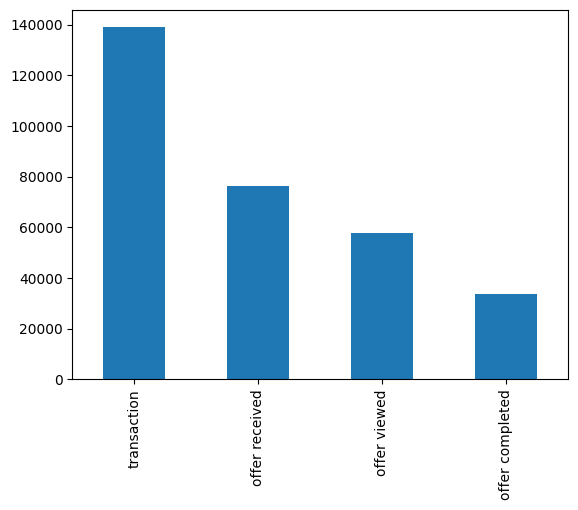

In [17]:
transcript_clean["event"].value_counts().plot.bar()

#### 3.4 Summary about transcript data:
- all offer_id in trascript dataframe is existed in portfolio
- all person_id in transcript dataframe is existed in profile
- Number of transaction event is the highest, it makes sense. 

### Build model
1. Prepare the data
2. Split the data to 70% for training, 30% testing
3. Using model: Random Forest and Decision Tree

#### 1. Experiment 1

##### 1.1 Prepare the data

In [19]:
transcript_pivot = transcript_clean.pivot_table(index=['person', 'offer_id'], columns='event', values='time', fill_value=None).reset_index()
transcript_pivot.head(5)

event,person,offer_id,offer completed,offer received,offer viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,576.0,NaN
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,336.0,372.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,NaN,168.0,192.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,414.0,408.0,456.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,528.0,504.0,540.0


In [43]:
# Merge all 3 dataframes into one dataframe
merge_dataframe = transcript_pivot[["person","offer_id","offer completed"]]
merge_dataframe_rename = merge_dataframe.rename(columns={"person": "person_id"})
profile_rename = profile.rename(columns={"id": "person_id"})
merge_dataframe_rename = merge_dataframe_rename.merge(profile_rename)
portfolio_rename = portfolio.rename(columns={"id": "offer_id"})
merge_dataframe_rename = merge_dataframe_rename.merge(portfolio_rename)
merge_dataframe_rename.head(5)

,person_id,offer_id,offer completed,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,M,33.0,20170421,72000.0,2,10,7,discount,1,1,0,1
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,NaN,F,19.0,20160809,65000.0,2,10,7,discount,1,1,0,1
2,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,NaN,M,56.0,20171209,47000.0,2,10,7,discount,1,1,0,1
3,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,696.0,None,NaN,20160503,NaN,2,10,7,discount,1,1,0,1
4,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,534.0,F,58.0,20171207,119000.0,2,10,7,discount,1,1,0,1


In [44]:
merge_dataframe_rename.loc[~merge_dataframe_rename["offer completed"].isna(),"offer completed"]=1
merge_dataframe_rename.loc[merge_dataframe_rename["offer completed"].isna(),"offer completed"]=0
merge_dataframe_rename.head(5)


,person_id,offer_id,offer completed,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,M,33.0,20170421,72000.0,2,10,7,discount,1,1,0,1
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,0.0,F,19.0,20160809,65000.0,2,10,7,discount,1,1,0,1
2,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,0.0,M,56.0,20171209,47000.0,2,10,7,discount,1,1,0,1
3,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,1.0,None,NaN,20160503,NaN,2,10,7,discount,1,1,0,1
4,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,1.0,F,58.0,20171207,119000.0,2,10,7,discount,1,1,0,1


In [45]:
# Remove the row that has Nan
merge_dataframe_rename = merge_dataframe_rename.dropna()
merge_dataframe_rename.head(5)

,person_id,offer_id,offer completed,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,M,33.0,20170421,72000.0,2,10,7,discount,1,1,0,1
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,0.0,F,19.0,20160809,65000.0,2,10,7,discount,1,1,0,1
2,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,0.0,M,56.0,20171209,47000.0,2,10,7,discount,1,1,0,1
4,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,1.0,F,58.0,20171207,119000.0,2,10,7,discount,1,1,0,1
5,00840a2ca5d2408e982d56544dc14ffd,2906b810c7d4411798c6938adc9daaa5,1.0,M,26.0,20141221,61000.0,2,10,7,discount,1,1,0,1


array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'income'}>],
       [<AxesSubplot: title={'center': 'difficulty'}>,
        <AxesSubplot: title={'center': 'reward'}>]], dtype=object)

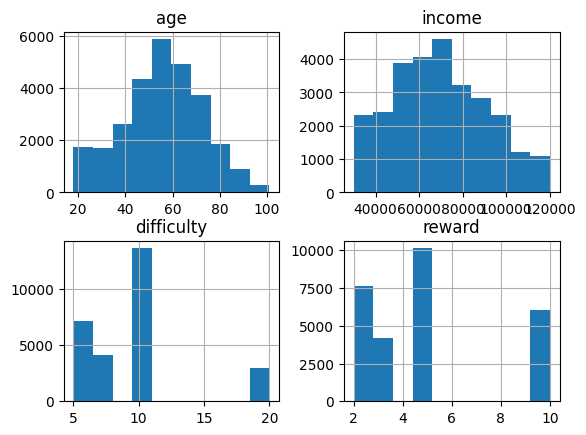

In [46]:
#EDA age, income, difficulty, reward on offer completed
merge_dataframe_rename[merge_dataframe_rename["offer completed"]==1.0][["age","income","difficulty","reward"]].hist()

array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'income'}>],
       [<AxesSubplot: title={'center': 'difficulty'}>,
        <AxesSubplot: title={'center': 'reward'}>]], dtype=object)

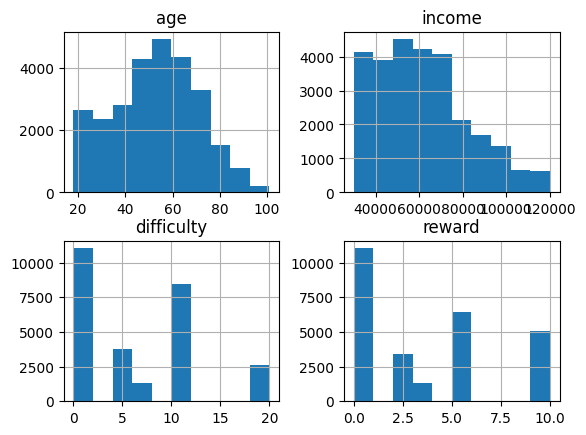

In [47]:
merge_dataframe_rename[merge_dataframe_rename["offer completed"]==0.0][["age","income","difficulty","reward"]].hist()

In [48]:
merge_dataframe_rename = merge_dataframe_rename.drop(["person_id","offer_id"],axis=1)
merge_dataframe_rename.head(5)

,offer completed,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,1.0,M,33.0,20170421,72000.0,2,10,7,discount,1,1,0,1
1,0.0,F,19.0,20160809,65000.0,2,10,7,discount,1,1,0,1
2,0.0,M,56.0,20171209,47000.0,2,10,7,discount,1,1,0,1
4,1.0,F,58.0,20171207,119000.0,2,10,7,discount,1,1,0,1
5,1.0,M,26.0,20141221,61000.0,2,10,7,discount,1,1,0,1


In [49]:
merge_dataframe_rename["offer_type"] = merge_dataframe_rename["offer_type"].astype('category').cat.codes
merge_dataframe_rename["gender"] = merge_dataframe_rename["gender"].astype('category').cat.codes
merge_dataframe_rename

,offer completed,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,1.0,1,33.0,20170421,72000.0,2,10,7,1,1,1,0,1
1,0.0,0,19.0,20160809,65000.0,2,10,7,1,1,1,0,1
2,0.0,1,56.0,20171209,47000.0,2,10,7,1,1,1,0,1
4,1.0,0,58.0,20171207,119000.0,2,10,7,1,1,1,0,1
5,1.0,1,26.0,20141221,61000.0,2,10,7,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63283,1.0,1,40.0,20170216,32000.0,10,10,7,0,1,1,1,0
63284,1.0,0,67.0,20170219,77000.0,10,10,7,0,1,1,1,0
63285,0.0,1,20.0,20180315,44000.0,10,10,7,0,1,1,1,0
63286,1.0,0,59.0,20170831,93000.0,10,10,7,0,1,1,1,0


In [50]:
X = merge_dataframe_rename.drop(["offer completed"],axis=1)
Y = merge_dataframe_rename["offer completed"]

##### 1.2 Split the data

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


ACCURACY OF THE MODEL:  0.7710731848423488


##### 1.3 Build the model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

rfc = RandomForestClassifier(n_estimators = 100)  
dtc = DecisionTreeClassifier()  


##### 1.4 Result

In [ ]:
rfc.fit(X_train, y_train)
# performing predictions on the test dataset
y_pred = rfc.predict(X_test)
  
# metrics are used to find accuracy or error
from sklearn import metrics    
# using metrics module for accuracy calculation
print("ACCURACY OF RANDOM FOREST MODEL: ", metrics.f1_score(y_test, y_pred))

In [52]:

dtc.fit(X_train, y_train)
# performing predictions on the test dataset
y_pred = dtc.predict(X_test)
  
# metrics are used to find accuracy or error
from sklearn import metrics    
# using metrics module for accuracy calculation
print("ACCURACY OF DECISION TREE MODEL: ", metrics.f1_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.730679156908665


#### 2. Experiment 2
Cluster some column into the group to reduce the dispersion of the data.

##### 2.1 Prepare Data

In [53]:
# Cluster the became_member_on into year_member
merge_dataframe_finetuning_1 = merge_dataframe_rename
merge_dataframe_finetuning_1["became_member_on"] = merge_dataframe_finetuning_1["became_member_on"].astype(str).str[:4]
merge_dataframe_finetuning_1

# Cluster the age into age group
age_bins = [18, 24, 29, 39, 49, 60, float('inf')]
age_labels = ['18-24', '25-29', '30-39', '40-49', '50-60', '60+']

merge_dataframe_finetuning_1['age'] = pd.cut(merge_dataframe_finetuning_1["age"], bins=age_bins, labels=age_labels, right=False)
merge_dataframe_finetuning_1

,offer completed,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,1.0,1,30-39,2017,72000.0,2,10,7,1,1,1,0,1
1,0.0,0,18-24,2016,65000.0,2,10,7,1,1,1,0,1
2,0.0,1,50-60,2017,47000.0,2,10,7,1,1,1,0,1
4,1.0,0,50-60,2017,119000.0,2,10,7,1,1,1,0,1
5,1.0,1,25-29,2014,61000.0,2,10,7,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63283,1.0,1,40-49,2017,32000.0,10,10,7,0,1,1,1,0
63284,1.0,0,60+,2017,77000.0,10,10,7,0,1,1,1,0
63285,0.0,1,18-24,2018,44000.0,10,10,7,0,1,1,1,0
63286,1.0,0,50-60,2017,93000.0,10,10,7,0,1,1,1,0


In [54]:
merge_dataframe_finetuning_1["age"] = merge_dataframe_finetuning_1["age"].astype('category').cat.codes


In [55]:
merge_dataframe_finetuning_1.head(5)

,offer completed,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,1.0,1,2,2017,72000.0,2,10,7,1,1,1,0,1
1,0.0,0,0,2016,65000.0,2,10,7,1,1,1,0,1
2,0.0,1,4,2017,47000.0,2,10,7,1,1,1,0,1
4,1.0,0,4,2017,119000.0,2,10,7,1,1,1,0,1
5,1.0,1,1,2014,61000.0,2,10,7,1,1,1,0,1


##### 2.2 Split data

In [4]:
X_finetuning_1 = merge_dataframe_finetuning_1.drop(["offer completed"],axis=1)
Y_finetuning_1 = merge_dataframe_finetuning_1["offer completed"]
X_train, X_test, y_train, y_test = train_test_split(X_finetuning_1, Y_finetuning_1, test_size=0.3, random_state=42)

NameError: name 'train_test_split' is not defined

##### 2.3 Build the model

In [ ]:
rfc_1 = RandomForestClassifier(n_estimators = 100)  
dtc_1 = DecisionTreeClassifier()  


##### 2.4 Result

In [56]:


rfc_1.fit(X_train, y_train)
# performing predictions on the test dataset
y_pred = rfc_1.predict(X_test)
  
# metrics are used to find accuracy or error
from sklearn import metrics    
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.7282549646888392


In [57]:

dtc_1.fit(X_train, y_train)
# performing predictions on the test dataset
y_pred = dtc_1.predict(X_test)
  
# metrics are used to find accuracy or error
from sklearn import metrics    
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.f1_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.696821821821822


### Conclusion
- I have created two version of data: original data and clustered data. 
- In the clustered data, I decide to group the age, became_member_on

| Model         | Original version  | Clustered version | 
| -----------   | ----------------- | ------------------|
| Random Forest | 0.77              |0.72               |
| Decision Tree | 0.73              |0.69               |

The original version is the best structure of data for both prediction model. The number is the F1-score in the test dataset

### Future Work
Looking for the another version of structure of data to optimize the accuracy of the model